In [1]:
from dnn import *
import numpy as np
import csv
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json

### Loading MNIST train set from csv file

MNIST files used in this notebook were downloaded from https://www.kaggle.com/oddrationale/mnist-in-csv.

In [2]:
mnist_train_x = []
mnist_train_y = []
with open('mnist/mnist_train.csv') as fp:
    train_csv = csv.reader(fp, delimiter=',')
    for row in train_csv:
        mnist_train_x += [[[int(i) for i in row[1:]]]]
        mnist_train_y += [int(row[0])]
mnist_train_x = np.array(mnist_train_x)   
mnist_train_y = np.array(mnist_train_y) 

### Splitting train set into validation and train sets

In [3]:
mnist_train_x, mnist_val_x, mnist_train_y, mnist_val_y = train_test_split(mnist_train_x, mnist_train_y, test_size=0.2, random_state=42)

### Loading MNIST test set from csv file

In [4]:
mnist_test_x = []
mnist_test_y = []
with open('mnist/mnist_test.csv') as fp:
    test_csv = csv.reader(fp, delimiter=',')
    for row in test_csv:
        mnist_test_x += [[[int(i) for i in row[1:]]]]
        mnist_test_y += [int(row[0])]
mnist_test_x = np.array(mnist_test_x)   
mnist_test_y = np.array(mnist_test_y) 

#### Function to plot a MNIST image from its pixels array 

In [5]:
def PlotMNIST(img, label, pred=None):
    img = np.array(img, dtype='uint8')
    img = img.reshape((28, 28)) #Converting the image to its 28x28 final shape
    
    if pred:
        title = 'Label:{} / Prediction:{}'.format(label, pred)
    else:
        title = 'Label:{}'.format(label)
        
    plt.title(title) #The title includes the label of the image that should be given as input
    plt.imshow(img, cmap='gray')
    plt.show()

#### Function to plot the evolution of the accuracy evaluated with the validation set from a log dictionary

In [6]:
def PlotLog(log):
    x = [int(k) for k in log.keys()] #Getting the keys of the dictionary which should be the epochs
    y = [v for v in log.values()] #Accuracy measured with the validation set for the corresponding epoch
    
    plt.plot(x, y, color='firebrick')
    plt.grid(axis='y')
    plt.title('Accuracy on the validation set')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

#### Set of  functions needed to train and test the NN on the MNIST dataset

In [7]:
#Function that receives a neural network and its input and returns the corresponding prediction of the input's label
#x should be a numpy array
def predict_MNIST(nn, x):
    x = x.T 
    r = nn.forward(x)[-1].T[0]
    return np.argmax(r)

#Function that receives the neural network, the train and validations sets and the number of epochs and performs
#both the training and the validation of the neural network using said sets
def TrainValMNIST(nn, train_x, train_y, val_x, val_y, epochs):
    log = {}
    for epoch in range(epochs):
        TrainMNIST(nn, train_x, train_y, epoch+1)
        acc = TestMNIST(nn, val_x, val_y)
        log[str(epoch+1)] = acc
    return log

#Function that receives the neural network, the train set and the number of epochs and trains the nn     
def TrainMNIST(nn, train_x, train_y, epoch):
    size = len(train_y)
    bar = tqdm(zip(train_x, train_y), total=size, leave=False)
    for x,y in bar:
        bar.set_postfix({'Train':'', 'Epoch': epoch})
        x_ = x.T/255
        y_ = np.zeros((10,1))
        y_[y][0] = 1.
        r = nn.forward(x_)
        d = nn.backpropagation(r,y_)
        nn.grad_descent(d)

#Function that receives the neural network and the test set and returns the accuracy of the network in said set
def TestMNIST(nn, test_x, test_y):
    correct = 0
    for x,y in zip(test_x, test_y):
        r = predict_MNIST(nn, x)
        if r == y:
            correct += 1
    return correct/len(test_y)    

## Testing the implementation of the network with MNIST

The Neural Network is created by initializing a NN object which should have as inputs the following:

- $(id, hd_1, ... ,hd_n, od)$ is a n+2-tuple where $id$ is the dimension of the input, $od$ is the dimension of the output and $hd_k$ is the dimension of hidden layer $k$.
- actf is a string with the name of the activation function used in all layers of the network. Currently it is only possible to choose between 'sigmoid' and 'relu'. If not chosen, 'sigmoid' is the default.
- lossf is the loss function used to evaluate the predictions of the network. Currently the only available choice is 'mse', which denotes the Mean Squared Error function. This is also set by default.
- lr is the learning rate, which is by default equal to $0.001$.

In [21]:
nn = NN((784,50,50,10), actf='sigmoid', lossf='mse', lr=0.005)

Training and getting the evaluation of the accuracy on the validation set as a log dictionary.

In [22]:
log = TrainValMNIST(nn, mnist_train_x, mnist_train_y, mnist_val_x, mnist_val_y, epochs=30)

It is possible to save the weights of the network in a .json file to loaded later.

In [30]:
filename = 'nn_mnist_trained.json' #name of the file where the model is going to be saved
nn.save_weights(filename)

#### Example of the plot of a log dictionary

This example results from training a neural network with two hidden layers of 50 nodes for 30 epochs, using MNIST as dataset.
Below is the plot of the accuracy on the validation set over consecutive epochs of training. 

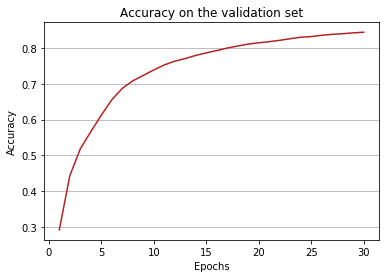

In [8]:
#Loading and example of a log dictionary of a real training from .json file
with open('log_validation.json', 'r') as file:
    pretrained_log = json.load(file)

#Plotting accuracy
PlotLog(pretrained_log)

#### Example of neural network and test set accuracy

The neural network loaded here is the result of training from scracth the neural network whose accuracy on the validation set is show above.

In [9]:
#Loading a NN previously trained  and saved (as shown above) from .json file
pretrained_nn = NN((784,50,50,10))
pretrained_nn.load_weights('nn_mnist_trained.json')

Accuracy of the loaded NN on the test set.

In [11]:
acc_test = TestMNIST(pretrained_nn, mnist_test_x, mnist_test_y)
print('Test set accuracy:', acc_test)

Test set accuracy: 0.85


#### Testing the prediction of the loaded NN on some of the images of the test set

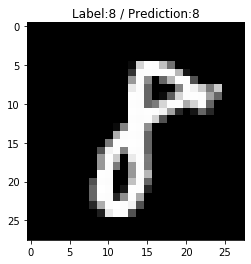

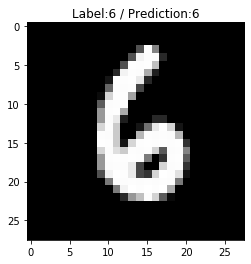

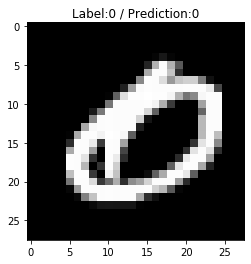

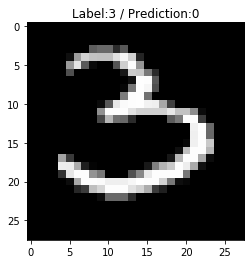

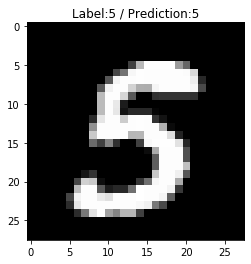

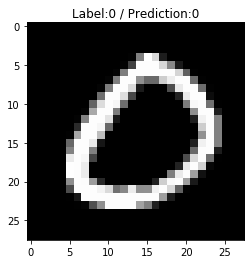

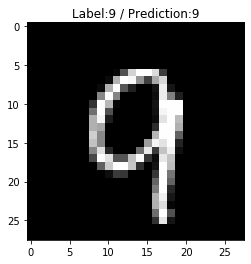

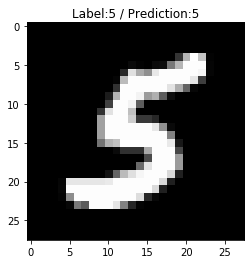

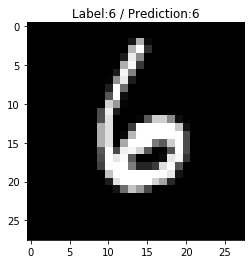

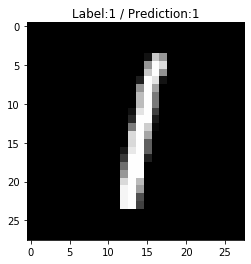

In [13]:
#list index was obtained randomly with the command np.random.choice([i for i in range(len(mnist_test_x))], size=10)
index = [1912, 1974, 5108, 2351, 4762, 8619, 2696, 7397, 1578, 5902]

for idx in index:
    PlotMNIST(mnist_test_x[idx], mnist_test_y[idx], pred=str(predict_MNIST(pretrained_nn, mnist_test_x[idx])))